In [1]:
%pylab inline

import os

import itertools as it
from scipy.optimize import leastsq
from string import join
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from densitycontour import densitycontour

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
write_tables_for_fig4 = False

def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"])
                               for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

def deg(t, m, p0):
    t0, Z0 = p0
    return m*array(t) + (Z0-m*t0)

def unbiased_disc(model_spec, model_jpas, residual_spec, residual_jpas):
    return (model_jpas-model_spec) - (median(residual_jpas)-median(residual_spec))

od = os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper/")

greys_map = cm._generate_cmap(greys_map_name, 256)
greys_map_r = cm._generate_cmap(greys_map_name+"_r", 256)
diver_map = cm._generate_cmap(diver_map_name, 256)
seque_map = cm._generate_cmap(seque_map_name, 256)

In [3]:
#READ TABLES

emission_detections = loadtxt("../inputs/real_deal/jpas_residual_emission.txt", dtype=str)
Lfrac = put_FITS_names(genfromtxt("data/RealDeal/lumfrac.txt", dtype=None, names=True))
snr_spec = genfromtxt("data/RealDeal/snr_spec.txt", dtype=None, names=True)
snr_jpas = genfromtxt("data/RealDeal/snr_jpas.txt", dtype=None, names=True)
Cind = put_FITS_names(genfromtxt("data/RealDeal/conIndex_test.txt", dtype=None, names=True))
u_lib, g_lib, r_lib, i_lib, z_lib = loadtxt("../inputs/tta_cb13/ssag/set_catalog.txt", usecols=range(1,1+5), unpack=True)
catalog = genfromtxt("data/RealDeal/catalog.txt", dtype=None, names=True)
gal2005 = genfromtxt("data/RealDeal/gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])

outs = os.path.expandvars("$phd/inputs/real_deal/outs")
change_name = lambda name, strip: "spSpec"+name.lstrip(strip).replace(".log", ".fit")

spec_ne = genfromtxt("{}/spec/dynbas_output.log".format(outs), dtype=None, names=True)
spec_ne["input_file"] = array([change_name(name, "dynbasfit_processed_SPEC_") for name in spec_ne["input_file"]])
spec_ne["M_mod"] = log10(spec_ne["M_mod"])

jpas_ne = genfromtxt("{}/nem_jpas/dynbas_output.log".format(outs), dtype=None, names=True)
jpas_ne["input_file"] = array([change_name(name, "dynbasfit_processed_nem_JPAS_") for name in jpas_ne["input_file"]])
jpas_ne["M_mod"] = log10(jpas_ne["M_mod"])
                                                           
parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])

In [4]:
#COMMON MASKS
in_spec_ne = array([galaxy in spec_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_jpas_ne = array([galaxy in jpas_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_gal2005 = array([galaxy in gal2005["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
g05_in_sam = array([galaxy in spec_ne["input_file"] for galaxy in gal2005["input_file"]], dtype=bool)
sam_in_g05 = array([galaxy in gal2005["input_file"] for galaxy in spec_ne["input_file"]], dtype=bool)
nem_detect = ~array([galaxy in emission_detections for galaxy in spec_ne["input_file"]], dtype=bool)

#COMMON QUANTITIES
col = (catalog["u_mag"] - catalog["r_mag"])[in_spec_ne]
cat = catalog[in_spec_ne]
lfr = Lfrac[in_spec_ne]
con, rat = array([[
            row["petroR90_r"]/row["petroR50_r"],
            3.0/row["petroR90_r"]
        ] if row["petroR50_r"]!=0 and row["petroR90_r"]!=0 else [inf, inf] for row in Cind[in_spec_ne]]).T
g05 = gal2005[g05_in_sam]
print "tables match?", all(spec_ne["input_file"]==cat["input_file"])&all(cat["input_file"]==lfr["input_file"])&\
                       all(cat["input_file"]==Cind["input_file"][in_spec_ne])&\
                       all(cat["input_file"][sam_in_g05]==g05["input_file"])

#SAMPLE DEFINITION MASKS
# mask for g05 subsamples
SF_hSNR_g05_mask = (sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]>15.0)
SF_hSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]>15.0)
Pa_hSNR_g05_mask = (sam_in_g05)&(col>=2.22)&(snr_spec["snr_wall"]>15.0)
# mask for cat subsamples
SF_lSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr_spec["snr_wall"]<=15.0)
Pa_lSNR_m16_mask = (~sam_in_g05)&(col>=2.22)&(snr_spec["snr_wall"]<=15.0)

# mask for removing trash
clean = nem_detect&(snr_spec["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)
clean = clean&(col>=1)&(col<=3.3)&(snr_jpas["npix_CaII"]>0)&(snr_jpas["npix_CaHK"]>0)

# masks for MPA-Garching subsample filtering
mask_m16 = clean&(sam_in_g05)
mask_g05 = clean[sam_in_g05]

# masks for galaxies classification
sfgs = col<2.22
pags = col>=2.22
algs = sfgs|pags

#WRITE DISCREPANCY TABLES(?)
if write_tables_for_fig4:
    savetxt("data/PhotoNearAnalysis/ur_color.txt", col[clean])
    for i, field in enumerate(spec_ne.dtype.names):
        if i in [2,3,4,5,6,7]:
            savetxt("data/PhotoNearAnalysis/JPAS_{0}.txt".format(field), jpas_ne[clean][field])
            savetxt("data/PhotoNearAnalysis/SPEC_{0}.txt".format(field), spec_ne[clean][field])
    write_tables_for_fig4 = True
    print "tables written"

tables match? True


In [5]:
NR = 20

con_lbs = dict(
    M=r"$\delta\log{M_\star}$",
    log_t_M=r"$\delta\left<\log{t_\star}\right>_M$",
    log_t_L=r"$\delta\left<\log{t_\star}\right>_L$",
    log_Z_M=r"$\delta\left<\log{Z_\star}\right>_M$",
    log_Z_L=r"$\delta\left<\log{Z_\star}\right>_L$",
    Av=r"$\delta A_V$"
)

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in fields]

jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

jpas_res = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
tta_con = dict(
    M=unbiased_disc(spec_tta["M_mod"], jpas_tta["M_mod"], spec_res["M"], jpas_res["M"]),
    log_t_M=unbiased_disc(spec_tta["log_t_M_mod"], jpas_tta["log_t_M_mod"], spec_res["log_t_M"], jpas_res["log_t_M"]),
    log_t_L=unbiased_disc(spec_tta["log_t_L_mod"], jpas_tta["log_t_L_mod"], spec_res["log_t_L"], jpas_res["log_t_L"]),
    log_Z_M=unbiased_disc(spec_tta["log_Z_M_mod"], jpas_tta["log_Z_M_mod"], spec_res["log_Z_M"], jpas_res["log_Z_M"]),
    log_Z_L=unbiased_disc(spec_tta["log_Z_L_mod"], jpas_tta["log_Z_L_mod"], spec_res["log_Z_L"], jpas_res["log_Z_L"]),
    Av=unbiased_disc(spec_tta["Av_mod"], jpas_tta["Av_mod"], spec_res["Av"], jpas_res["Av"])
)
obs_con = dict(
    M=unbiased_disc(spec_ne["M_mod"], jpas_ne["M_mod"], spec_res["M"], jpas_res["M"]),
    log_t_M=unbiased_disc(spec_ne["log_t_M_mod"], jpas_ne["log_t_M_mod"], spec_res["log_t_M"], jpas_res["log_t_M"]),
    log_t_L=unbiased_disc(spec_ne["log_t_L_mod"], jpas_ne["log_t_L_mod"], spec_res["log_t_L"], jpas_res["log_t_L"]),
    log_Z_M=unbiased_disc(spec_ne["log_Z_M_mod"], jpas_ne["log_Z_M_mod"], spec_res["log_Z_M"], jpas_res["log_Z_M"]),
    log_Z_L=unbiased_disc(spec_ne["log_Z_L_mod"], jpas_ne["log_Z_L_mod"], spec_res["log_Z_L"], jpas_res["log_Z_L"]),
    Av=unbiased_disc(spec_ne["Av_mod"], jpas_ne["Av_mod"], spec_res["Av"], jpas_res["Av"])
)
g05_con = dict(
    M=spec_ne["M_mod"][mask_m16]-g05["M_mod"][mask_g05],
    log_t_L=spec_ne["log_t_L_mod"][mask_m16]-g05["log_t_L_mod"][mask_g05],
    log_Z_L=spec_ne["log_Z_L_mod"][mask_m16]-g05["log_Z_L_mod"][mask_g05]
)

In [6]:
print "SF_hSNR_g05:", SF_hSNR_g05_mask.sum()
print "SF_hSNR_m16:", SF_hSNR_m16_mask.sum()
print "Pa_hSNR_g05:", Pa_hSNR_g05_mask.sum()
print "SF_lSNR_m16:", SF_lSNR_m16_mask.sum()
print "Pa_lSNR_m16:", Pa_lSNR_m16_mask.sum()
print
print "Total      :", SF_hSNR_g05_mask.sum()+SF_hSNR_m16_mask.sum()+Pa_hSNR_g05_mask.sum()+SF_lSNR_m16_mask.sum()+\
                      Pa_lSNR_m16_mask.sum()

SF_hSNR_g05: 3575
SF_hSNR_m16: 1719
Pa_hSNR_g05: 5887
SF_lSNR_m16: 1608
Pa_lSNR_m16: 144

Total      : 12933


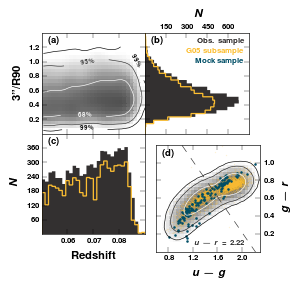

In [7]:
fig = figure(figsize=(2.5, 2.5))

gs1 = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, left=0, top=1)
ax00 = fig.add_subplot(gs1[0, 0], xticklabels=[])
ax01 = fig.add_subplot(gs1[0, 1])
ax10 = fig.add_subplot(gs1[1, 0])

ax01.tick_params(labelleft=False, labelbottom=False, labeltop=True)
ax01.xaxis.set_label_position("top")

gs2 = matplotlib.gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1, left=0, top=1, right=0.95, bottom=0.05)
ax11 = fig.add_subplot(gs2[1, 1])

ax11.tick_params(labelleft=False, labelright=True)
ax11.yaxis.set_label_position("right")

axs = array([[ax00, ax01], [ax10, ax11]])
# ---------------------------------------------------------------------------
axs[0,0].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
axs[0,0].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
axs[0,0].text(0.05, 0.90, r"\bf (a)", fontsize="small", ha="left", transform=axs[0,0].transAxes)
rx = axs[0,0].set_xlim(0.05, 0.09)
ry = axs[0,0].set_ylim(0.00, 1.4)
axs[0,0].set_ylabel(r'\bf 3"/R90')

H, xe, ye = histogram2d(cat["redshift"][clean], rat[clean], (30,30), [last(30,rx),last(30,ry)])
H = gaussian_filter(H, sigma=1.5)
H[H==0] = 1
den = axs[0,0].pcolormesh(xe[:-1], ye[:-1], log10(H.T), cmap=greys_map, vmin=0.0, vmax=2.0, edgecolor="face")

sample_data = densitycontour.ScatterData(cat["redshift"][clean], rat[clean])
raster = sample_data.rasterize(nbins_x=30, nbins_y=30, clipping=[last(30,rx),last(30,ry)])
raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
cont = contours.plot((0.99,0.95,0.68), axes=axs[0,0], linewidths=0.5, cmap=greys_map_r)
contours.cilabel(cont, fontsize=5, fmt=r"\bf %.0f", inline=True)
# ---------------------------------------------------------------------------
axs[0,1].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
axs[0,1].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
axs[0,1].text(0.05, 0.90, r"\bf (b)", fontsize="small", ha="left", transform=axs[0,1].transAxes)
axs[0,1].text(0.95, 0.90, r"\bf Obs. sample", color=samples["dark"], fontsize="x-small", ha="right", transform=axs[0,1].transAxes)
axs[0,1].text(0.95, 0.80, r"\bf G05 subsample", color=samples["warm"], fontsize="x-small", ha="right", transform=axs[0,1].transAxes)
axs[0,1].text(0.95, 0.70, r"\bf Mock sample", color=samples["cold"], fontsize="x-small", ha="right", transform=axs[0,1].transAxes)
rg = axs[0,1].set_ylim(0.0, 1.4)
axs[0,1].set_xlabel(r"\bf $N$")
axs[0,1].hist(rat[clean], 30, histtype="stepfilled", lw=0, color=samples["dark"], range=rg, orientation="horizontal")
axs[0,1].hist(rat[mask_m16], 30, histtype="step", lw=1, color=samples["warm"], range=rg, orientation="horizontal")
# ---------------------------------------------------------------------------
axs[1,0].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
axs[1,0].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
axs[1,0].text(0.05, 0.90, r"\bf (c)", fontsize="small", ha="left", transform=axs[1,0].transAxes)
rg = axs[1,0].set_xlim(0.05, 0.09)
axs[1,0].set_xlabel(r'\bf Redshift')
axs[1,0].set_ylabel(r"\bf $N$")
axs[1,0].hist(cat["redshift"][clean], 30, histtype="stepfilled", lw=0, color=samples["dark"], range=rg)
axs[1,0].hist(cat["redshift"][mask_m16], 30, histtype="step", lw=1, color=samples["warm"], range=rg)
# ---------------------------------------------------------------------------
axs[1,1].xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
axs[1,1].yaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
xl, yl = axs[1,1].set_xlim(0.6, 2.3), axs[1,1].set_ylim(0.0, 1.2)
axs[1,1].text(0.05, 0.90, r"\bf (d)", fontsize="small", ha="left", transform=axs[1,1].transAxes)
axs[1,1].set_xlabel(r"\bf $u-g$")
axs[1,1].set_ylabel(r"\bf $g-r$")

H, xe, ye = histogram2d((cat["u_mag"]-cat["g_mag"])[clean], (cat["g_mag"]-cat["r_mag"])[clean], (30,30), [last(30,xl),last(30,yl)])
H = gaussian_filter(H, sigma=1.5)
H[H==0] = 1
den = axs[1,1].pcolormesh(xe[:-1], ye[:-1], log10(H.T), cmap=greys_map, vmin=0.0, vmax=3.0, edgecolor="face")

axs[1,1].scatter((cat["u_mag"]-cat["g_mag"])[mask_m16], (cat["g_mag"]-cat["r_mag"])[mask_m16], lw=0, c=samples["warm"], s=1, alpha=0.2)

axs[1,1].scatter(u_lib-g_lib, g_lib-r_lib, lw=0, c=samples["cold"], s=4)
axs[1,1].plot(xl, 2.22-array(xl), "--", color="0.2", lw=0.5)
axs[1,1].text(0.85, 0.08, r"\bf $u-r=2.22$", ha="right", fontsize="x-small", color="0.2", transform=axs[1,1].transAxes)

sample_data = densitycontour.ScatterData((cat["u_mag"]-cat["g_mag"])[clean], (cat["g_mag"]-cat["r_mag"])[clean])
raster = sample_data.rasterize(nbins_x=30, nbins_y=30, clipping=[last(30,xl),last(30,yl)])
raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
cont = contours.plot((0.99,0.95,0.68), axes=axs[1,1], linewidths=0.5, cmap=greys_map_r)
# ---------------------------------------------------------------------------

fig.savefig("{}sample_chars".format(od))

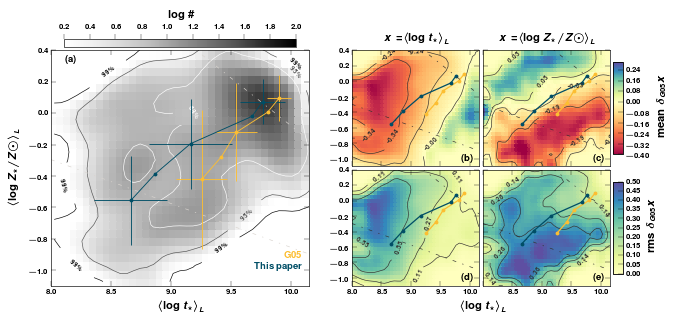

In [68]:
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
table = spec_ne
N, bins = histogram(col[mask_m16], 3, (1.3,3.0))
slopes = [-0.28, -0.45, -0.61]
sl_col = [samples["cold"], "0.9", samples["warm"]]
x, y = "log_t_L_mod", "log_Z_L_mod"
xr, yr = "log_t_L", "log_Z_L"
red_lb = xr, yr
red_st = mean, rms_flat
red_nm = "mean", "rms"
ab = ["b c".split(), "d e".split()]
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(7, 3.3))

ax0 = subplot2grid((21, 44), (1, 0), rowspan=20, colspan=20, xlabel=params[xr], ylabel=params[yr], xlim=rx, ylim=ry)
ac0 = subplot2grid((21, 44), (0, 1), colspan=18)

ax11 = subplot2grid((21, 44), (1, 23), rowspan=10, colspan=10, title=r"\bf $x=${}".format(params[xr]), xticklabels=[], xlim=rx, ylim=ry)
ax12 = subplot2grid((21, 44), (1, 33), rowspan=10, colspan=10, title=r"\bf $x=${}".format(params[yr]), xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)
ax21 = subplot2grid((21, 44), (11, 23), rowspan=10, colspan=10, xlim=rx, ylim=ry)
ax22 = subplot2grid((21, 44), (11, 33), rowspan=10, colspan=10, yticklabels=[], xlim=rx, ylim=ry)
ac1 = subplot2grid((21, 44), (2, 43), rowspan=8)
ac2 = subplot2grid((21, 44), (12, 43), rowspan=8)

axs = array([[ax11, ax12], [ax21, ax22]])
acs = array([ac1, ac2])

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#--------------------------------------------------------------------------------------------------------------------------
axs[1,1].set_xlabel(params[xr], x=0.0)
axs[1,1].set_xticklabels([""]+list(axs[1,1].get_xticklabels()[1:]))

H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_al = gaussian_filter(H_al, sigma=1.5)
H_al[H_al==0] = 1
den = ax0.pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=greys_map, vmin=0.2, vmax=2.0, edgecolor="face")
cb0 = colorbar(den, cax=ac0, orientation="horizontal")
cb0.set_label(r"\bf \log{\#}")
ac0.tick_params(direction="out", bottom=False, top=True, labelbottom=False, labeltop=True)
ac0.xaxis.set_label_position("top")

sample_data = densitycontour.ScatterData(table[x][mask_m16], table[y][mask_m16])
raster = sample_data.rasterize(nbins_x=nbins[0], nbins_y=nbins[1], clipping=[last(nbins[0],rx),last(nbins[1],ry)])
raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
cont = contours.plot((0.99,0.95,0.68), axes=ax0, linewidths=0.5, cmap=greys_map_r)
contours.cilabel(cont, fontsize=5, fmt=r"\bf %.0f", inline=True)

for ibin in xrange(bins.size-1):
    if ibin==1: continue
    if ibin<bins.size-2:
        bin_mask = (col[mask_m16]>=bins[ibin])&(col[mask_m16]<bins[ibin+1])
    else:
        bin_mask = (col[mask_m16]>=bins[ibin])&(col[mask_m16]<=bins[ibin+1])
    p0 = median(table[x][mask_m16][bin_mask]), median(table[y][mask_m16][bin_mask])
    ax0.plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.5, color=samples["light"])

cg05, tg05, tg05_rms = binner(col[mask_m16], g05[x][mask_g05], 5, (1.3,3.0), "mean")
cg05, Zg05, Zg05_rms = binner(col[mask_m16], g05[y][mask_g05], 5, (1.3,3.0), "mean")
cm16, tm16, tm16_rms = binner(col[mask_m16], table[x][mask_m16], 5, (1.3,3.0), "mean")
cm16, Zm16, Zm16_rms = binner(col[mask_m16], table[y][mask_m16], 5, (1.3,3.0), "mean")

ax0.errorbar(tg05, Zg05, Zg05_rms, tg05_rms, "-o", sl_col[2], mew=0, ms=3, lw=0.7, color=sl_col[2], errorevery=2, zorder=99)
ax0.errorbar(tm16, Zm16, Zm16_rms, tm16_rms, "-o", sl_col[0], mew=0, ms=3, lw=0.7, color=sl_col[0], errorevery=2, zorder=99)
ax0.text(0.97, 0.07, r"\bf This paper", color=sl_col[0], fontsize="small", ha="right", transform=ax0.transAxes)
ax0.text(0.97, 0.12, r"\bf G05", color=sl_col[2], fontsize="small", ha="right", transform=ax0.transAxes)
ax0.text(0.05, 0.95, r"\bf (a)", fontsize="small", ha="left", transform=ax0.transAxes)
#--------------------------------------------------------------------------------------------------------------------------
for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    H_al, xe, ye = histogram2d(table[x][mask_m16], table[y][mask_m16], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    Z = redux_histogram2d(xe, ye, table[x][mask_m16], table[y][mask_m16], g05_con[[xr,yr][j]], stat=red_st[i], fill=0.0)
    Z = gaussian_filter(Z, sigma=1.5)
    
    lv = map(round, percentile(Z, [25.0,50.0,75.0]), [2]*3)
    rz_i, rz_f = map(round, percentile(Z, [0.0,100.0]), [1]*2)

    red = axs[i,j].pcolormesh(xe[:-1], ye[:-1], Z.T, cmap=diver_map, vmin=rz_i, vmax=rz_f, norm=MidpointNormalize(midpoint=0.0), edgecolor="face")

    cb = colorbar(red, cax=acs[i])
    cb.set_label(r"\bf %s $\delta_{G05} x$"%(red_nm[i]))

    cont = axs[i,j].contour(xe[:-1], ye[:-1], Z.T, lv, colors=samples["dark"], linewidths=0.5, linestyles="-")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

    axs[i,j].plot(tg05, Zg05, "-o", mew=0, ms=3, color=sl_col[2])
    axs[i,j].plot(tm16, Zm16, "-o", mew=0, ms=3, color=sl_col[0])
    
    axs[i,j].text(0.95, 0.05, r"\bf (%s)"%ab[i][j], fontsize="small", ha="right", transform=axs[i,j].transAxes)
    
    for ibin in xrange(bins.size-1):
        if ibin==1: continue
        if ibin<bins.size-2:
            bin_mask = (col[mask_m16]>=bins[ibin])&(col[mask_m16]<bins[ibin+1])
        else:
            bin_mask = (col[mask_m16]>=bins[ibin])&(col[mask_m16]<=bins[ibin+1])
        p0 = median(table[x][mask_m16][bin_mask]), median(table[y][mask_m16][bin_mask])
        axs[i,j].plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.5, color=samples["dark"])

fig.savefig("{}{}".format(od, "spec_AMR_con_maps"))

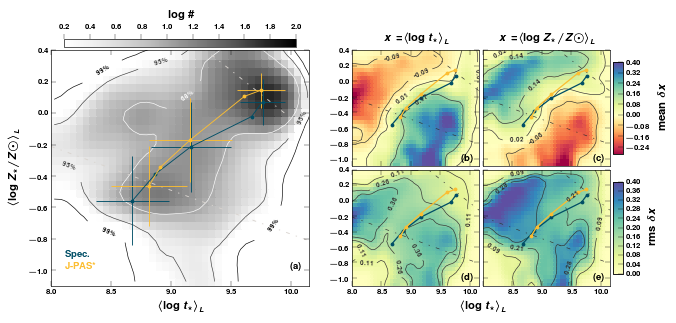

In [69]:
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
table = jpas_ne
N, bins = histogram(col[clean], 3, (1.3,3.0))
slopes = [-0.28, -0.45, -0.61]
sl_col = [samples["warm"], "0.9", samples["cold"]]
x, y = "log_t_L_mod", "log_Z_L_mod"
xr, yr = "log_t_L", "log_Z_L"
red_lb = xr, yr
red_st = mean, rms_flat
red_nm = "mean", "rms"
ab = ["b c".split(), "d e".split()]
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(7, 3.3))

ax0 = subplot2grid((21, 44), (1, 0), rowspan=20, colspan=20, xlabel=params[xr], ylabel=params[yr], xlim=rx, ylim=ry)
ac0 = subplot2grid((21, 44), (0, 1), colspan=18)

ax11 = subplot2grid((21, 44), (1, 23), rowspan=10, colspan=10, title=r"\bf $x=${}".format(params[xr]), xticklabels=[], xlim=rx, ylim=ry)
ax12 = subplot2grid((21, 44), (1, 33), rowspan=10, colspan=10, title=r"\bf $x=${}".format(params[yr]), xticklabels=[], yticklabels=[], xlim=rx, ylim=ry)
ax21 = subplot2grid((21, 44), (11, 23), rowspan=10, colspan=10, xlim=rx, ylim=ry)
ax22 = subplot2grid((21, 44), (11, 33), rowspan=10, colspan=10, yticklabels=[], xlim=rx, ylim=ry)
ac1 = subplot2grid((21, 44), (2, 43), rowspan=8)
ac2 = subplot2grid((21, 44), (12, 43), rowspan=8)

axs = array([[ax11, ax12], [ax21, ax22]])
acs = array([ac1, ac2])

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#--------------------------------------------------------------------------------------------------------------------------
axs[1,1].set_xlabel(params[xr], x=0.0)
axs[1,1].set_xticklabels([""]+list(axs[1,1].get_xticklabels()[1:]))

H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
H_al = gaussian_filter(H_al, sigma=1.5)
H_al[H_al==0] = 1
den = ax0.pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=greys_map, vmin=0.2, vmax=2.0, edgecolor="face")
cb0 = colorbar(den, cax=ac0, orientation="horizontal")
cb0.set_label(r"\bf \log{\#}")
ac0.tick_params(direction="out", bottom=False, top=True, labelbottom=False, labeltop=True)
ac0.xaxis.set_label_position("top")

sample_data = densitycontour.ScatterData(table[x][clean], table[y][clean])
raster = sample_data.rasterize(nbins_x=nbins[0], nbins_y=nbins[1], clipping=[last(nbins[0],rx),last(nbins[1],ry)])
raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
cont = contours.plot((0.99,0.95,0.68), axes=ax0, linewidths=0.5, cmap=greys_map_r)
contours.cilabel(cont, fontsize=5, fmt=r"\bf %.0f", inline=True)

for ibin in xrange(bins.size-1):
    if ibin==1: continue
    if ibin<bins.size-2:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
    else:
        bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])
    p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
    ax0.plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.7, color=samples["light"])

cspec, tspec, tspec_rms = binner(col[clean], spec_ne[x][clean], 5, (1.3,3.0), "mean")
cspec, Zspec, Zspec_rms = binner(col[clean], spec_ne[y][clean], 5, (1.3,3.0), "mean")
cm16, tm16, tm16_rms = binner(col[clean], table[x][clean], 5, (1.3,3.0), "mean")
cm16, Zm16, Zm16_rms = binner(col[clean], table[y][clean], 5, (1.3,3.0), "mean")

ax0.errorbar(tspec, Zspec, Zspec_rms, tspec_rms, "-o", sl_col[2], mew=0, ms=3, lw=0.7, color=sl_col[2], errorevery=2, zorder=99)
ax0.errorbar(tm16, Zm16, Zm16_rms, tm16_rms, "-o", sl_col[0], mew=0, ms=3, lw=0.7, color=sl_col[0], errorevery=2, zorder=99)
ax0.text(0.05, 0.07, r"\bf J-PAS*", color=sl_col[0], fontsize="small", ha="left", transform=ax0.transAxes)
ax0.text(0.05, 0.12, r"\bf Spec.", color=sl_col[2], fontsize="small", ha="left", transform=ax0.transAxes)
ax0.text(0.97, 0.07, r"\bf (a)", fontsize="small", ha="right", transform=ax0.transAxes)
#--------------------------------------------------------------------------------------------------------------------------
for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    H_al, xe, ye = histogram2d(table[x][clean], table[y][clean], nbins, [last(nbins[0],rx),last(nbins[1],ry)])
    Z = redux_histogram2d(xe, ye, table[x][clean], table[y][clean], obs_con[red_lb[j]][clean], stat=red_st[i], fill=0.0)
    Z = gaussian_filter(Z, sigma=1.5)
    
    lv = map(round, percentile(Z, [25.0,50.0,75.0]), [2]*3)
    rz_i, rz_f = map(round, percentile(Z, [0.0,100.0]), [1]*2)

    red = axs[i,j].pcolormesh(xe[:-1], ye[:-1], Z.T, cmap=diver_map, vmin=rz_i, vmax=rz_f, norm=MidpointNormalize(midpoint=0.0), edgecolor="face")

    cb = colorbar(red, cax=acs[i])
    cb.set_label(r"\bf {} $\delta x$".format(red_nm[i]))
    
    cont = axs[i,j].contour(xe[:-1], ye[:-1], Z.T, lv, colors=samples["dark"], linewidths=0.5, linestyles="-")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)
    
    axs[i,j].plot(tspec, Zspec, "-o", mew=0, ms=3, color=sl_col[2])
    axs[i,j].plot(tm16, Zm16, "-o", mew=0, ms=3, color=sl_col[0])

    axs[i,j].text(0.95, 0.05, r"\bf (%s)"%ab[i][j], fontsize="small", ha="right", transform=axs[i,j].transAxes)

    for ibin in xrange(bins.size-1):
        if ibin==1: continue
        if ibin<bins.size-2:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<bins[ibin+1])
        else:
            bin_mask = (col[clean]>=bins[ibin])&(col[clean]<=bins[ibin+1])
        p0 = median(table[x][clean][bin_mask]), median(table[y][clean][bin_mask])
        axs[i,j].plot(rx, deg(rx, slopes[ibin], p0), "-.", lw=0.5, color=samples["dark"])

fig.savefig("{}{}".format(od, "jpas_AMR_con_maps"))

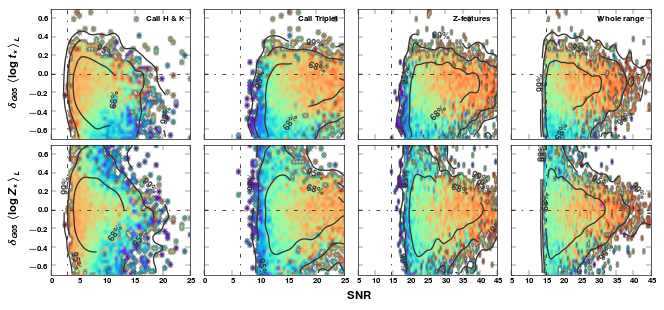

In [10]:
table = snr_spec[mask_m16]
t_mask = snr_spec[mask_m16]["snr_wall"]>=15.0
disc = g05_con
xs, ys = ("snr_CaHK", "snr_CaII", "snr_Zfea", "snr_wall"), ("log_t_L", "log_Z_L")
x_lbs = [r"\bf SNR", [r"\bf CaII H \& K", r"\bf CaII Triplet", r"\bf Z-features", r"\bf Whole range"]]
y_lbs = delta_g05[ys[0]], delta_g05[ys[1]]
nbins = (50, 40), (80, 40)
rxs, ry = ((0.0, 25.0), (5.0, 45.0)), (-0.7,+0.7)
#--------------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(2, 4, figsize=(7.0,3.3), sharex="col", sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.05)

ylim(ry)

for i, j in it.product(range(axs.shape[0]), range(axs.shape[1])):
    x, y = xs[j], ys[i]
    if j<=1:
        rx = rxs[0]
        nb = nbins[0]
    else:
        rx = rxs[1]
        nb = nbins[1]

    H, xe, ye = histogram2d(table[x], disc[y], nb, [last(nb[0],rx),last(nb[1],ry)])
    H = redux_histogram2d(xe, ye, table[x], disc[y], col[mask_m16], stat=mean, fill=np.nan)
    H = ma.masked_array(H, mask=isnan(H))
    den = axs[i,j].pcolormesh(xe[:-1], ye[:-1], H.T, cmap=seque_map, vmin=1.3, vmax=3.0, shading="gouraud")
    sample_data = densitycontour.ScatterData(table[x], disc[y])
    raster = sample_data.rasterize(nbins_x=nb[0], nbins_y=nb[1], clipping=[last(nb[0],rx),last(nb[1],ry)])
    raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
    contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
    cont = contours.plot((0.99,0.95,0.68), axes=axs[i,j], linewidths=1.0, colors=samples["dark"])
    contours.cilabel(cont, fontsize=7, fmt=r"\bf %.0f", inline=True)

    axs[i,j].axhline(ls="-.", color=samples["dark"], lw=0.7)
    axs[i,j].axvline(min(table[x][t_mask]), ls="-.", color=samples["dark"], lw=0.7)

    axs[i,j].set_xlim(rx)

    if j==0: axs[i,j].set_ylabel(y_lbs[i])
    if i==0: axs[i,j].text(0.95, 0.95, x_lbs[1][j], fontsize="x-small", va="top", ha="right", transform=axs[i,j].transAxes)

axs[1,2].set_xlabel(x_lbs[0], x=0)

fig.savefig("{}{}".format(od, "con_snr_maps_g05"))

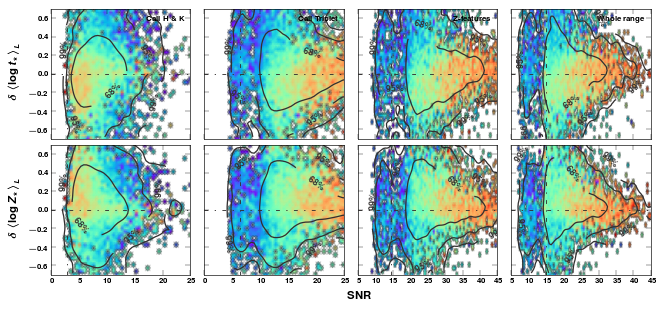

In [11]:
#Acá pareciera que a mayor SNR en CaII H y K, las discrepancias entre J-PAS* y la espectroscopía (galaxias reales)
#incrementa hacia las galaxias más azules, una tendencia más clara en edad. Eso no tiene mucho sentido y pensé que
#podría haber un sesgo de selección en la muestra, del tipo: las galaxias azules tienen espectros con mejor SNR en
#CaII H y K por X o Y, a pesar de su SNR en otras regiones espectrales. Eso igual no tiene mucho sentido pero ya que
#la selección de las azules fue diferente a la de galaxias rojas, podían aparecer tendencias raras en los espectros.
#El hecho es que las SNR en todas las regiones espectrales correlacionan entre sí como uno espera, por ejemplo: a
#mayor SNR en CaII H y K, mayor SNR en el triplete de CaII y así sucesivamente.


table = snr_spec
t_mask = snr_spec["snr_wall"]>=15.0
disc = obs_con
xs, ys = ("snr_CaHK", "snr_CaII", "snr_Zfea", "snr_wall"), ("log_t_L", "log_Z_L")
x_lbs = [r"\bf SNR", [r"\bf CaII H \& K", r"\bf CaII Triplet", r"\bf Z-features", r"\bf Whole range"]]
y_lbs = delta[ys[0]], delta[ys[1]]
nbins = (50, 40), (80, 40)
rxs, ry = ((0.0, 25.0), (5.0, 45.0)), (-0.7,+0.7)
#--------------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(2, 4, figsize=(7.0,3.3), sharex="col", sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.05)

ylim(ry)

for i, j in it.product(range(axs.shape[0]), range(axs.shape[1])):
    x, y = xs[j], ys[i]
    if j<=1:
        rx = rxs[0]
        nb = nbins[0]
    else:
        rx = rxs[1]
        nb = nbins[1]

    H, xe, ye = histogram2d(table[x][clean], disc[y][clean], nb, [last(nb[0],rx),last(nb[1],ry)])
    H = redux_histogram2d(xe, ye, table[x][clean], disc[y][clean], col[clean], stat=mean, fill=np.nan)
    H = ma.masked_array(H, mask=isnan(H))
    den = axs[i,j].pcolormesh(xe[:-1], ye[:-1], H.T, cmap=seque_map, vmin=1.3, vmax=3.0, shading="gouraud")
    sample_data = densitycontour.ScatterData(table[x][clean], disc[y][clean])
    raster = sample_data.rasterize(nbins_x=nb[0], nbins_y=nb[1], clipping=[last(nb[0],rx),last(nb[1],ry)])
    raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
    contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
    cont = contours.plot((0.99,0.95,0.68), axes=axs[i,j], linewidths=1.0, colors=samples["dark"])
    contours.cilabel(cont, fontsize=7, fmt=r"\bf %.0f", inline=True)

    axs[i,j].axhline(ls="-.", color=samples["dark"], lw=0.7)
    axs[i,j].axvline(min(table[x][clean&t_mask]), ls="-.", color=samples["dark"], lw=0.7)

    axs[i,j].set_xlim(rx)

    if j==0: axs[i,j].set_ylabel(y_lbs[i])
    if i==0: axs[i,j].text(0.95, 0.95, x_lbs[1][j], fontsize="x-small", va="top", ha="right", transform=axs[i,j].transAxes)

axs[1,2].set_xlabel(x_lbs[0], x=0)

fig.savefig("{}{}".format(od, "con_snr_maps_spec"))

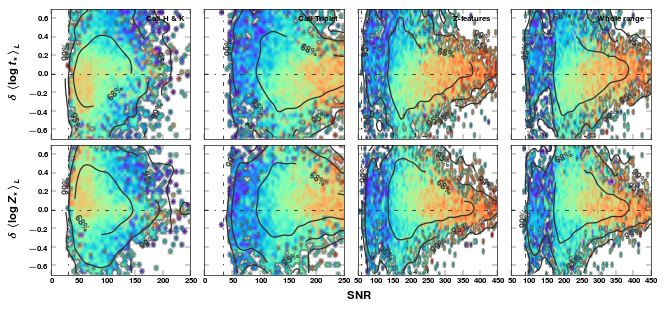

In [12]:
table = snr_jpas
t_mask = snr_jpas["snr_wall"]>=0.0
disc = obs_con
xs, ys = ("snr_CaHK", "snr_CaII", "snr_Zfea", "snr_wall"), ("log_t_L", "log_Z_L")
x_lbs = [r"\bf SNR", [r"\bf CaII H \& K", r"\bf CaII Triplet", r"\bf Z-features", r"\bf Whole range"]]
y_lbs = delta[ys[0]], delta[ys[1]]
nbins = (50, 40), (80, 40)
rxs, ry = ((0.0, 250.0), (50.0, 450.0)), (-0.7,+0.7)
#--------------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(2, 4, figsize=(7.0,3.3), sharex="col", sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.05)

ylim(ry)

for i, j in it.product(range(axs.shape[0]), range(axs.shape[1])):
    x, y = xs[j], ys[i]
    if j<=1:
        rx = rxs[0]
        nb = nbins[0]
    else:
        rx = rxs[1]
        nb = nbins[1]

    H, xe, ye = histogram2d(table[x][clean], disc[y][clean], nb, [last(nb[0],rx),last(nb[1],ry)])
    H = redux_histogram2d(xe, ye, table[x][clean], disc[y][clean], col[clean], stat=mean, fill=np.nan)
    H = ma.masked_array(H, mask=isnan(H))
    den = axs[i,j].pcolormesh(xe[:-1], ye[:-1], H.T, cmap=seque_map, vmin=1.3, vmax=3.0, shading="gouraud")
    sample_data = densitycontour.ScatterData(table[x][clean], disc[y][clean])
    raster = sample_data.rasterize(nbins_x=nb[0], nbins_y=nb[1], clipping=[last(nb[0],rx),last(nb[1],ry)])
    raster.pdf = gaussian_filter(raster.pdf, sigma=1.5)
    contours = densitycontour.NaiveContourVisualizer(raster, mode="nearest")
    cont = contours.plot((0.99,0.95,0.68), axes=axs[i,j], linewidths=1.0, colors=samples["dark"])
    contours.cilabel(cont, fontsize=7, fmt=r"\bf %.0f", inline=True)

    axs[i,j].axhline(ls="-.", color=samples["dark"], lw=0.7)
    axs[i,j].axvline(min(table[x][clean&t_mask]), ls="-.", color=samples["dark"], lw=0.7)

    axs[i,j].set_xlim(rx)

    if j==0: axs[i,j].set_ylabel(y_lbs[i])
    if i==0: axs[i,j].text(0.95, 0.95, x_lbs[1][j], fontsize="x-small", va="top", ha="right", transform=axs[i,j].transAxes)

axs[1,2].set_xlabel(x_lbs[0], x=0)

fig.savefig("{}{}".format(od, "con_snr_maps_jpas"))

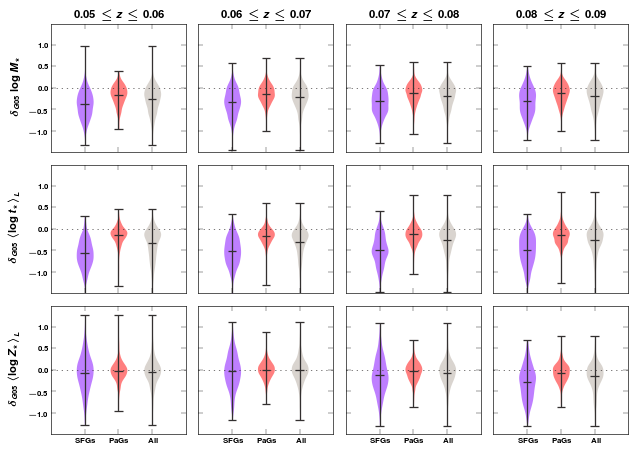

In [13]:
N_rs, ran_rs = 4, (0.05,0.09)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_L", "log_Z_L"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs[mask_m16], pags[mask_m16], algs[mask_m16]
lbs = r"\bf SFGs", r"\bf PaGs", r"\bf All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,5), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both')
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (cat[mask_m16]["redshift"]>=ran_rs[0]+j*step_rs)&(cat[mask_m16]["redshift"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"\bf $%.2f\leq z\leq%.2f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta_g05[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([g05_con[kws[i]][rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
fig.savefig("{}con_g05_vs_col_vs_redshift".format("img/"))

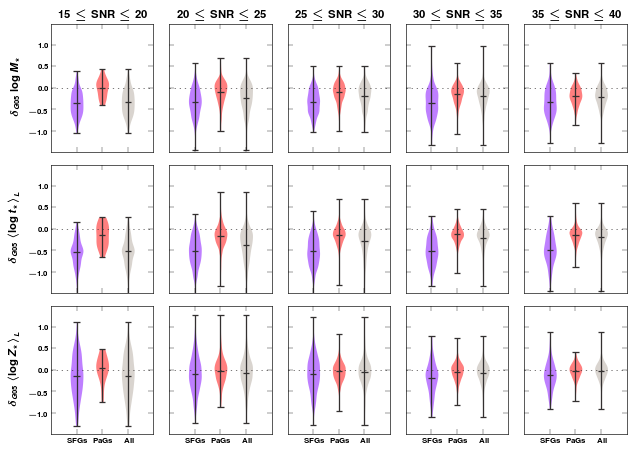

In [14]:
N_rs, ran_rs = 5, (15, 40)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_L", "log_Z_L"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs[mask_m16], pags[mask_m16], algs[mask_m16]
lbs = r"\bf SFGs", r"\bf PaGs", r"\bf All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,5), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both')
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec[mask_m16]["snr_Zfea"]>=ran_rs[0]+j*step_rs)&(snr_spec[mask_m16]["snr_Zfea"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"\bf $%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta_g05[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([g05_con[kws[i]][rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
fig.savefig("{}con_g05_vs_col_vs_snr_wall".format("img/"))

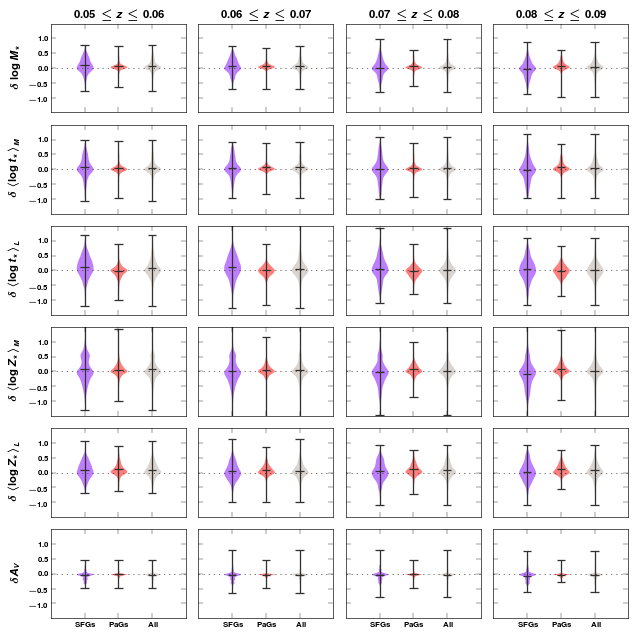

In [15]:
N_rs, ran_rs = 4, (0.05,0.09)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = r"\bf SFGs", r"\bf PaGs", r"\bf All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both')
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (cat["redshift"]>=ran_rs[0]+j*step_rs)&(cat["redshift"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"\bf $%.2f\leq z\leq%.2f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
fig.savefig("{}con_vs_col_vs_redshift".format("img/"))

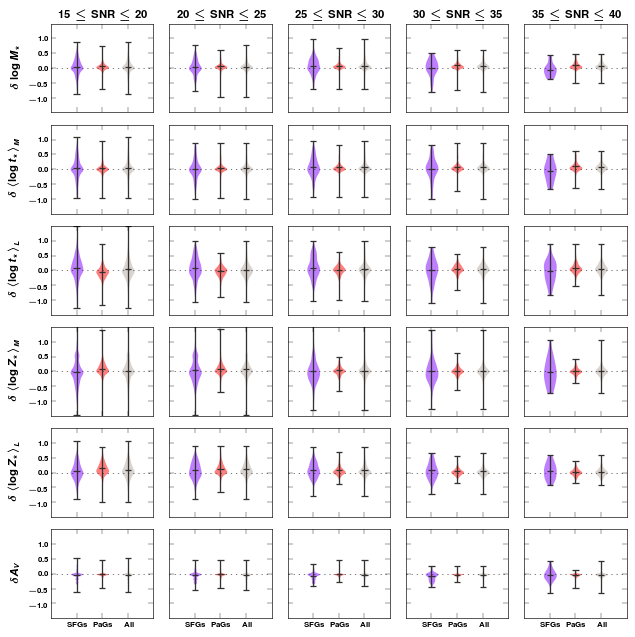

In [16]:
N_rs, ran_rs = 5, (15, 40)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = r"\bf SFGs", r"\bf PaGs", r"\bf All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both')
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_wall"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_wall"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"\bf $%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
fig.savefig("{}con_vs_col_vs_snr_wall".format("img/"))

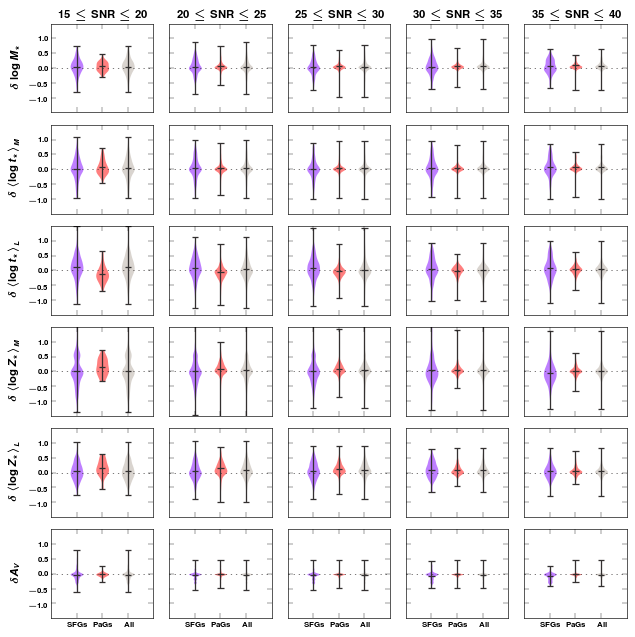

In [17]:
N_rs, ran_rs = 5, (15, 40)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = r"\bf SFGs", r"\bf PaGs", r"\bf All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both')
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_Zfea"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_Zfea"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"\bf $%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
fig.savefig("{}con_vs_col_vs_snr_zfea".format("img/"))

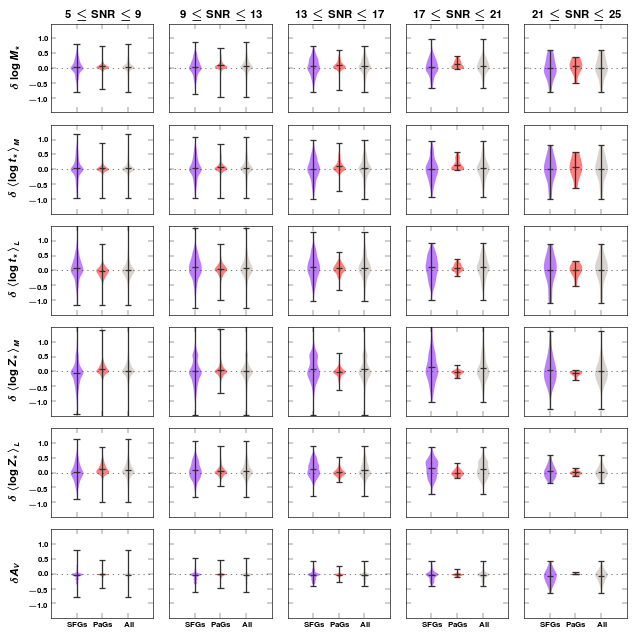

In [18]:
N_rs, ran_rs = 5, (5, 25)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = r"\bf SFGs", r"\bf PaGs", r"\bf All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both')
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_CaHK"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_CaHK"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"\bf $%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
fig.savefig("{}con_vs_col_vs_snr_cahk".format("img/"))

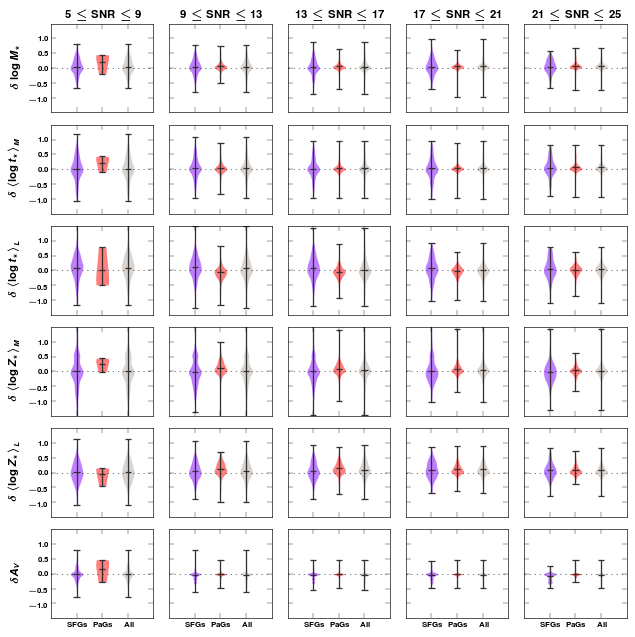

In [19]:
N_rs, ran_rs = 5, (5, 25)
step_rs = diff(ran_rs)[0]/N_rs
kws = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
xl, yl = (1.3, 3.0), (-1.5,+1.5)
masks = sfgs, pags, algs
lbs = r"\bf SFGs", r"\bf PaGs", r"\bf All"
cl = "#7F00FF", "#FF0000", samples["light"]
#--------------------------------------------------------------------------------------------------------------------
fig, axs = subplots(len(kws), N_rs, figsize=(7,7), sharex=True, sharey=True)
ylim(yl)

majorXLocator=plt.MaxNLocator(nbins=4,prune='both')
majorYLocator=plt.MaxNLocator(nbins=6,prune='both', symmetric=True)
for i, j in it.product(xrange(len(kws)), xrange(N_rs)):
    rs_mask = (snr_spec["snr_CaII"]>=ran_rs[0]+j*step_rs)&(snr_spec["snr_CaII"]<=ran_rs[0]+(j+1)*step_rs)

    axs[i,j].xaxis.set_major_locator(majorXLocator)
    axs[i,j].yaxis.set_major_locator(majorYLocator)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(r"\bf $%.0f\leq\text{SNR}\leq%.0f$"%(ran_rs[0]+j*step_rs, ran_rs[0]+(j+1)*step_rs))
    if axs[i,j].is_last_row(): axs[i,j].set_xticklabels(lbs)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(delta[kws[i]])
    if rs_mask.sum()<1: continue

    v = axs[i,j].violinplot([obs_con[kws[i]][clean&rs_mask&mask] for mask in masks], showmeans=True, widths=0.5)
    axs[i,j].axhline(ls=":", lw=0.5, color=samples["dark"])
    
    v["cbars"].set_color(samples["dark"])
    v["cmins"].set_color(samples["dark"])
    v["cmaxes"].set_color(samples["dark"])
    v["cmeans"].set_color(samples["dark"])
    for k in xrange(len(masks)):
        v["bodies"][k].set_linewidth(0)
        v["bodies"][k].set_facecolor(cl[k])
        if k<2:
            v["bodies"][k].set_alpha(0.5)
        else:
            v["bodies"][k].set_alpha(1.0)

fig.tight_layout()
fig.savefig("{}con_vs_col_vs_snr_caii".format("img/"))

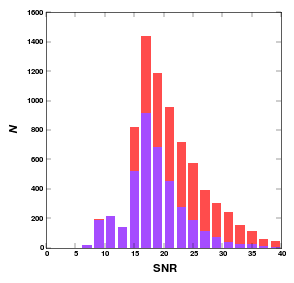

In [20]:
k = "snr_wall"
hist([snr_spec[k][clean&sfgs], snr_spec[k][clean&pags]], 20, range=(0,40), lw=0, histtype="barstacked", color=["#7F00FF", "#FF0000"], alpha=0.7)

xlabel(r"\bf SNR")
ylabel(r"\bf $N$")

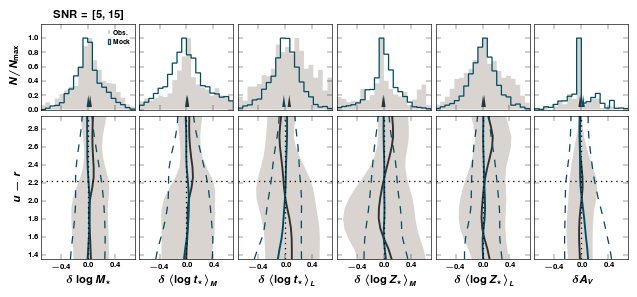

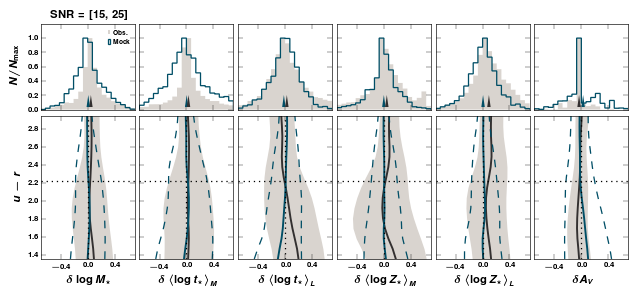

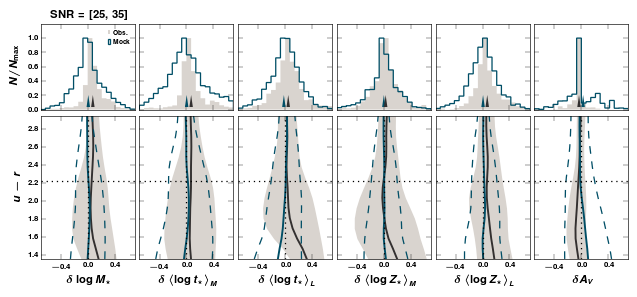

In [21]:
#J-PAS* esta tratando de ajustar bien CaII H y K, pero no tiene información al respecto. No hay bandas que resuelvan
#ese rasgo(?). 
residual_h, residual_b = tta_con, obs_con
color_h, color_b = samples["cold"], samples["light"]
label_h, label_b = r"\bf Mock", r"\bf Obs."
sed_type_h, sed_type_b = "tta", "obs"
clabels = r"\clogm \cmwla \clwla \cmwlz \clwlz \cextv".split()
kw = ["M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"]
nb = 15
xlm, ylm = (-0.7, 0.7), (1.3, 3.0)
#--------------------------------------------------------------------------------
bins = [(5, 15), (15, 25), (25, 35)]

for b in bins:
    mask = (b[0]<=snr_spec[k][clean])&(snr_spec[k][clean]<b[1])

    fig, axs = subplots(1, len(kw), figsize=(7, 3.3), sharex=True, sharey=True)

    axr = []
    for ax in axs:
        divider = make_axes_locatable(ax)
        axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))

        plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
        axr[-1].set_ylim(0, 1.2)

    axs = row_stack((axr, axs))

    axs[0, 0].set_xlim(xlm)
    axs[0, 0].set_xticks([-0.4, 0, 0.4])
    axs[0, 0].set_ylabel(r"\bf $N/N_\text{max}$")
    axs[1, 0].set_ylabel(r"\bf $u-r$")

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        if i==0:
            consistency_h = residual_h[kw[j]]
            consistency_b = residual_b[kw[j]][clean][mask]

            med_h = mean(consistency_h)
            med_b = mean(consistency_b)

            N_h = histogram(consistency_h, 20, range=xlm)[0].max().repeat(consistency_h.size)
            N_b = histogram(consistency_b, 20, range=xlm)[0].max().repeat(consistency_b.size)

            axs[i, j].hist(consistency_b, 20, range=xlm, weights=1.0/N_b, histtype="stepfilled", color=color_b, lw=0, label=label_b)
            axs[i, j].hist(consistency_h, 20, range=xlm, weights=1.0/N_h, histtype="step", color=color_h, label=label_h)

            med_h_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_h, 0.0)))+array([0,0.2])
            med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
            axs[i, j].annotate("", med_h_axes, (med_h,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_h,"ec":"none"})
            axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":samples["dark"],"ec":"none"})
        else:
            xh, yh, eh = binner(lcolor, residual_h[kw[j]], nb, ylm, "mean")
            xb, yb, eb = binner(col[clean][mask], residual_b[kw[j]][clean][mask], nb, ylm, "mean")

            axs[i, j].plot(gaussian_filter(yb,1.5), xb, "-", color=samples["dark"], lw=1.5)
            axs[i, j].fill_betweenx(xb, gaussian_filter(yb-eb[0],1.5), gaussian_filter(yb+eb[1],1.5), facecolor=color_b, lw=0)

            axs[i, j].plot(gaussian_filter(yh,1.5), xh, "-", color=color_h, lw=1.5)
            axs[i, j].plot(gaussian_filter(yh-eh[0],1.5), xh, "--", color=color_h, lw=1.0)
            axs[i, j].plot(gaussian_filter(yh+eh[1],1.5), xh, "--", color=color_h, lw=1.0)

            axs[i, j].axvline(ls=":", color="k")
            axs[i, j].axhline(2.22, ls=":", color="k")

            axs[i, j].set_xlabel(con_lbs[kw[j]])

    axs[0, 0].set_title(r"\bf $\text{SNR}=[%.0f,%.0f]$"%b)
    axs[1, 0].set_ylim(xh[0], xh[-1])
    axs[0, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05)

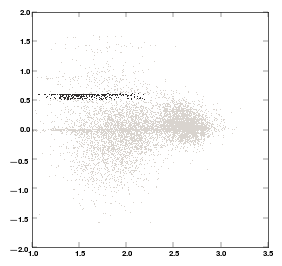

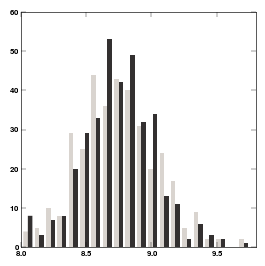

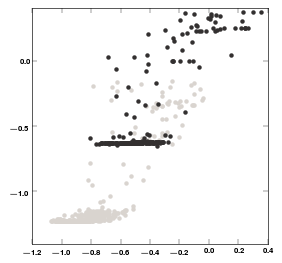

In [22]:
mask = (obs_con["log_Z_M"][clean]>0.5)&(obs_con["log_Z_M"][clean]<0.6)&sfgs[clean]
# mask = (obs_con["log_Z_M"][clean]>-0.01)&(obs_con["log_Z_M"][clean]<+0.01)&sfgs[clean]

figure()
plot(col[clean], obs_con["log_Z_M"][clean], ",", mew=0, color=samples["light"])
plot(col[clean][mask], obs_con["log_Z_M"][clean][mask], ",", mew=0, color=samples["dark"])

kw = "log_t_L_mod"
figure()
hist([spec_ne[kw][clean][mask], jpas_ne[kw][clean][mask]], 20, color=[samples["light"], samples["dark"]], lw=0)

figure()
plot(spec_ne["log_Z_L_mod"][clean][mask], spec_ne["log_Z_M_mod"][clean][mask], ".", color=samples["light"])
plot(jpas_ne["log_Z_L_mod"][clean][mask], jpas_ne["log_Z_M_mod"][clean][mask], ".", color=samples["dark"])

([array([ 292.,    5.,    4.,    5.,   12.,   25.,   13.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,  284.,    9.,    6.,    2.,   14.,    7.,   34.])],
 array([-1.229 , -1.0689, -0.9088, -0.7487, -0.5886, -0.4285, -0.2684,
        -0.1083,  0.0518,  0.2119,  0.372 ]),
 <a list of 2 Lists of Patches objects>)

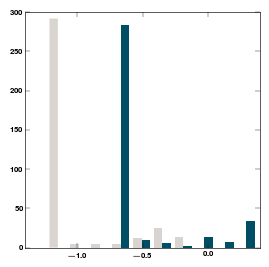

In [23]:
mask = (obs_con["log_Z_M"][clean]>0.5)&(obs_con["log_Z_M"][clean]<0.6)&sfgs[clean]
k = "log_Z_M_mod"
hist([spec_ne[k][clean][mask], jpas_ne[k][clean][mask]], lw=0, color=[samples["light"], samples["cold"]])

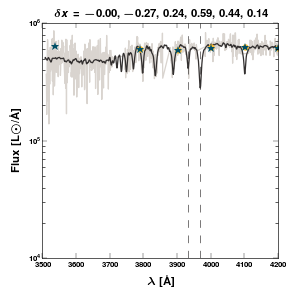

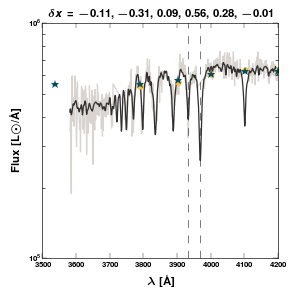

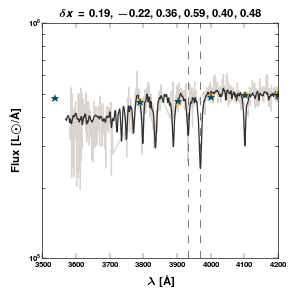

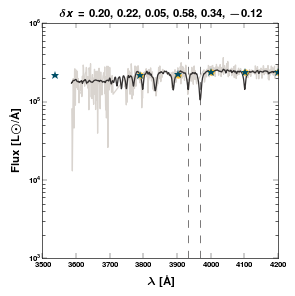

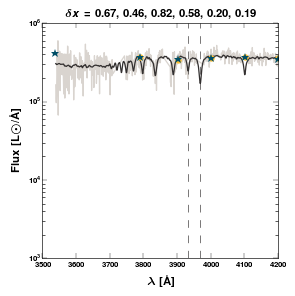

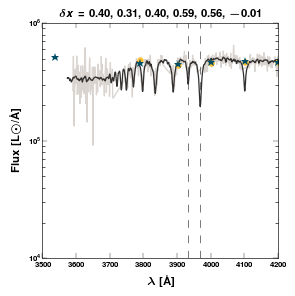

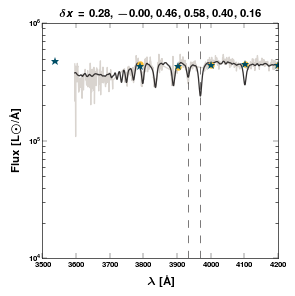

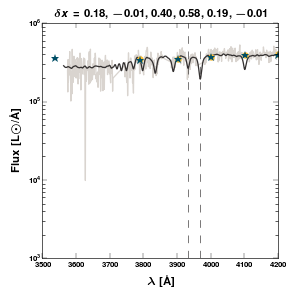

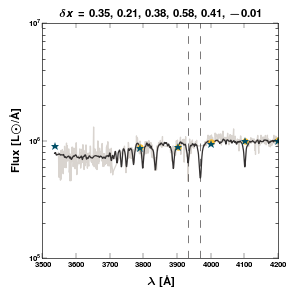

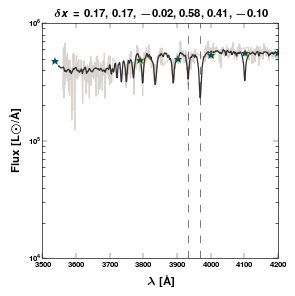

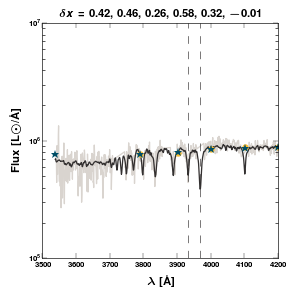

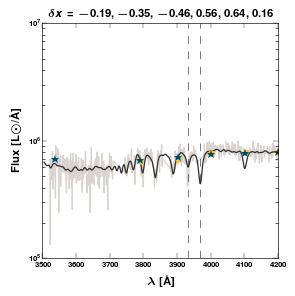

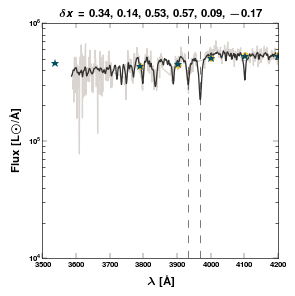

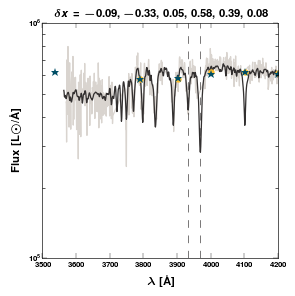

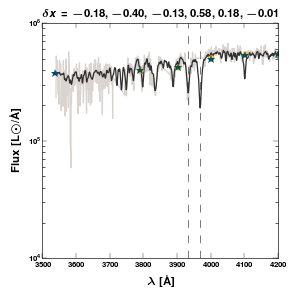

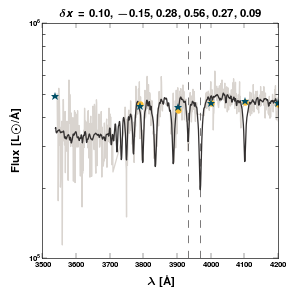

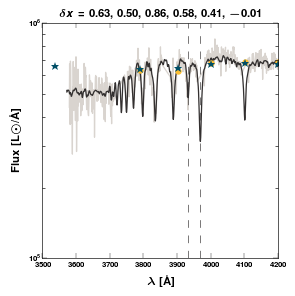

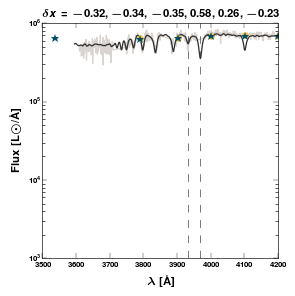

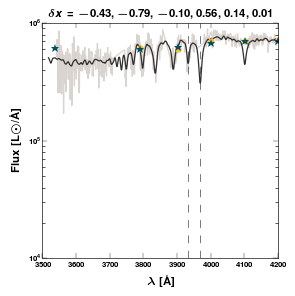

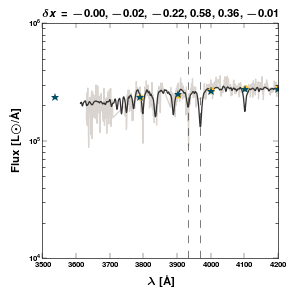

In [24]:
out_dir = os.path.expandvars("$phd/inputs/real_deal/outs/")
mask = (obs_con["log_Z_M"][clean]>0.55)&(obs_con["log_Z_M"][clean]<0.6)&sfgs[clean]
kw = ["M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"]
for i, n in enumerate(cat["input_file"][clean][mask][50:70]):
    jpas_out = "dynbasfit_processed_nem_JPAS_{}.log".format(n.strip(".fit"))
    spec_out = "dynbasfit_processed_SPEC_{}.log".format(n.strip(".fit"))
    
    wlj, flj, fjm = loadtxt("{}{}{}".format(out_dir, "nem_jpas/", jpas_out), usecols=(0,1,5), unpack=True)
    wls, fls, fsm = loadtxt("{}{}{}".format(out_dir, "spec/", spec_out), usecols=(0,1,5), unpack=True)
    
    figure()
    title(r"\bf $\delta x=%.2f,%.2f,%.2f,%.2f,%.2f,%.2f$"%tuple(obs_con[k][clean][mask][50:70][i] for k in kw))
    semilogy(wls[fls>0], fls[fls>0], "-", color=samples["light"])
    semilogy(wls, fsm, "-", color=samples["dark"])
    semilogy(wlj, flj, ".", color=samples["warm"], ms=10)
    semilogy(wlj, fjm, "*", color=samples["cold"], ms=7)
    axvline(3933.663, ls="--", lw=0.5, color=samples["dark"])
    axvline(3968.468, ls="--", lw=0.5, color=samples["dark"])

    xlim(3500, 4200)
    xlabel(r"\bf $\lambda$ [\AA]")
    ylabel(r"\bf Flux [L$\odot$/\AA]")

In [25]:
mask = (obs_con["log_Z_M"][clean]>0.5)&(obs_con["log_Z_M"][clean]<0.6)&sfgs[clean]
out_dir = os.path.expandvars("$phd/inputs/real_deal/outs/")
flux_diff = []
wlmax = 3700
kw = ["M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"]
for i, n in enumerate(cat["input_file"][clean]):
    jpas_out = "dynbasfit_processed_nem_JPAS_{}.log".format(n.strip(".fit"))
    spec_out = "dynbasfit_processed_SPEC_{}.log".format(n.strip(".fit"))
    
    wlj, flj, fjm = loadtxt("{}{}{}".format(out_dir, "nem_jpas/", jpas_out), usecols=(0,1,5), unpack=True)
    wls, fls, fsm = loadtxt("{}{}{}".format(out_dir, "spec/", spec_out), usecols=(0,1,5), unpack=True)
    
    flux_diff += [median(fjm[wlj<=wlmax])-median(fsm[wls<=wlmax])]
    

flux_diff = array(flux_diff)

(-1.5, 1.5)

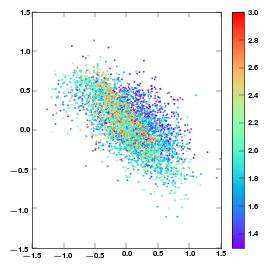

In [26]:
#scatter(obs_con["log_t_L"][clean&sfgs], obs_con["M"][clean&sfgs], s=4, c=log10(abs(flux_diff[sfgs[clean]])), lw=0, cmap=diver_map, vmin=4, vmax=5)
scatter(obs_con["log_t_L"][clean], obs_con["log_Z_L"][clean], s=2, lw=0, c=col[clean], cmap=seque_map, vmin=1.3, vmax=3)
colorbar()

ylim(xlim(-1.5,+1.5))

(2, 20)

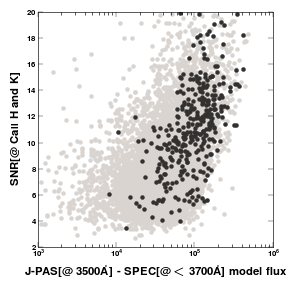

In [27]:
k = "log_Z_M"

mask = (obs_con["log_Z_M"][clean]>0.5)&(obs_con["log_Z_M"][clean]<0.6)&sfgs[clean]
# mask = (obs_con["log_Z_M"][clean]>-0.01)&(obs_con["log_Z_M"][clean]<+0.01)&sfgs[clean]
semilogx(flux_diff, snr_spec["snr_CaHK"][clean], ".", color=samples["light"])
semilogx(flux_diff[mask], snr_spec["snr_CaHK"][clean][mask], ".", ms=7, color=samples["dark"])

xlabel(r"\bf J-PAS[@ $3500$\AA] - SPEC[@ $<3700$\AA] model flux")
ylabel(r"\bf SNR[@ Ca\textsc{ii} H and K]")

xlim(1e3,1e6)
ylim(2,20)